In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgbm
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, roc_curve, roc_auc_score 
from sklearn.metrics import accuracy_score, precision_score, recall_score,precision_recall_curve, auc
from eli5.sklearn import PermutationImportance
from eli5.lightgbm import explain_weights_lightgbm
from xgboost import XGBClassifier
from collections import defaultdict
import shap
import eli5
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#the data used in this excercise was sourced from http://www.football-data.co.uk
df = pd.read_csv('./data/E0.csv')
df = df.append(pd.read_csv('./data/E0_2018.csv')).reset_index(drop=True)
print(df.head())

   AC  AF  AR  AS  AST  AY      AwayTeam  B365A  B365D  B365H  ...     PSCH  \
0   4  12   0   6    3   1     Leicester   6.50    4.5   1.53  ...     1.49   
1  10   9   0  14    4   2      Man City   1.33    5.5  11.00  ...    11.75   
2   5  11   0  10    5   3       Burnley  15.00    6.5   1.25  ...     1.33   
3   9  19   0   8    6   3  Huddersfield   5.00    3.6   1.83  ...     1.79   
4   7  10   0   9    1   1         Stoke   5.75    3.8   1.70  ...     1.82   

    PSD    PSH      Referee    VCA   VCD    VCH    WHA  WHD    WHH  
0  4.55   1.53       M Dean   6.50  4.50   1.53   6.00  4.2   1.53  
1  5.55  10.95     M Oliver   1.33  5.50  10.00   1.33  4.8  10.00  
2  6.30   1.26     C Pawson  15.00  6.25   1.25  13.00  5.5   1.25  
3  3.58   1.83       J Moss   5.00  3.60   1.83   5.00  3.3   1.80  
4  3.83   1.70  N Swarbrick   5.75  3.80   1.70   5.50  3.5   1.70  

[5 rows x 65 columns]


/home/srooney/.local/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 65 columns):
AC          569 non-null int64
AF          569 non-null int64
AR          569 non-null int64
AS          569 non-null int64
AST         569 non-null int64
AY          569 non-null int64
AwayTeam    569 non-null object
B365A       569 non-null float64
B365D       569 non-null float64
B365H       569 non-null float64
BWA         569 non-null float64
BWD         569 non-null float64
BWH         569 non-null float64
Bb1X2       569 non-null int64
BbAH        569 non-null int64
BbAHh       569 non-null float64
BbAv<2.5    569 non-null float64
BbAv>2.5    569 non-null float64
BbAvA       569 non-null float64
BbAvAHA     569 non-null float64
BbAvAHH     569 non-null float64
BbAvD       569 non-null float64
BbAvH       569 non-null float64
BbMx<2.5    569 non-null float64
BbMx>2.5    569 non-null float64
BbMxA       569 non-null float64
BbMxAHA     569 non-null float64
BbMxAHH     569 non-n

In [3]:
# There appears to be a set of odds that were not included in the 2018-2019 season, we'll remove these.
df = df.dropna(axis=1, how="any")

In [4]:
# Lets calculate the win % of the three outcomes from the matches.
res = dict(df.FTR.value_counts())
print('Home Team: {}%'.format(round(res['H']/(sum(res.values())), 2)),
     '\nAway Team: {}%'.format(round(res['A']/(sum(res.values())), 2)),
     '\nDraw: {}%'.format(round(res['D']/(sum(res.values())), 2)))

Home Team: 0.46% 
Away Team: 0.3% 
Draw: 0.24%


<h3>Over the past two EPL seasons, the home team has won 46% of matches. This will mark our baseline, if we picked home team to win every game we would be correct 46% of the time based of this data.</h3>

In [5]:
df.loc[df['FTR'] == 'H'].describe()

,AC,AF,AR,AS,AST,AY,B365A,B365D,B365H,BWA,...,PSCD,PSCH,PSD,PSH,VCA,VCD,VCH,WHA,WHD,WHH
count,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,...,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.00000,259.000000
mean,4.359073,10.579151,0.069498,9.694981,2.961390,1.571429,8.014826,4.989344,2.204903,7.368340,...,5.043436,2.225019,5.013552,2.216448,8.268803,4.960734,2.206834,7.571699,4.69471,2.183707
std,2.694817,3.464732,0.254792,4.376161,1.982104,1.215897,6.853486,2.212443,1.531899,5.949594,...,2.400835,1.492921,2.223686,1.527201,7.230835,2.192337,1.518672,6.372562,1.98715,1.497926
min,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,1.300000,3.000000,1.080000,1.300000,...,2.910000,1.070000,2.990000,1.100000,1.300000,3.000000,1.050000,1.300000,2.90000,1.060000
25%,2.000000,8.000000,0.000000,7.000000,1.000000,1.000000,3.200000,3.400000,1.280000,3.100000,...,3.405000,1.305000,3.440000,1.300000,3.190000,3.400000,1.300000,3.050000,3.30000,1.295000
50%,4.000000,10.000000,0.000000,9.000000,3.000000,1.000000,5.000000,3.900000,1.800000,4.750000,...,3.910000,1.810000,3.940000,1.830000,5.000000,3.900000,1.830000,4.600000,3.75000,1.830000
75%,6.000000,13.000000,0.000000,13.000000,4.000000,2.000000,12.000000,6.000000,2.450000,10.500000,...,5.990000,2.480000,6.105000,2.480000,11.750000,6.000000,2.450000,11.000000,5.50000,2.450000
max,13.000000,21.000000,1.000000,25.000000,9.000000,6.000000,34.000000,13.000000,12.000000,31.000000,...,15.000000,11.680000,13.000000,11.960000,34.000000,13.000000,12.000000,29.000000,13.00000,11.000000


In [6]:
df.loc[df['FTR'] == 'A'].describe()

,AC,AF,AR,AS,AST,AY,B365A,B365D,B365H,BWA,...,PSCD,PSCH,PSD,PSH,VCA,VCD,VCH,WHA,WHD,WHH
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,...,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,5.040462,10.526012,0.052023,12.936416,5.375723,1.572254,2.928613,4.089306,4.834335,2.833873,...,4.123295,4.898671,4.122717,4.777341,2.920058,4.093526,4.845318,2.878092,3.901329,4.549595
std,2.810608,3.434718,0.222718,4.648268,2.288213,1.230303,2.575406,1.099613,3.538646,2.316607,...,1.097950,3.398462,1.082216,3.342071,2.475306,1.079295,3.512443,2.594377,0.947078,3.122610
min,0.000000,3.000000,0.000000,3.000000,1.000000,0.000000,1.160000,3.000000,1.140000,1.150000,...,2.930000,1.170000,3.050000,1.140000,1.170000,3.000000,1.150000,1.150000,3.000000,1.120000
25%,3.000000,8.000000,0.000000,9.000000,4.000000,1.000000,1.570000,3.390000,2.370000,1.570000,...,3.380000,2.350000,3.430000,2.370000,1.600000,3.400000,2.380000,1.570000,3.300000,2.300000
50%,5.000000,11.000000,0.000000,13.000000,5.000000,1.000000,2.250000,3.750000,3.390000,2.150000,...,3.740000,3.450000,3.750000,3.440000,2.250000,3.750000,3.300000,2.150000,3.600000,3.300000
75%,7.000000,13.000000,0.000000,16.000000,7.000000,2.000000,3.390000,4.330000,6.500000,3.300000,...,4.480000,6.660000,4.450000,6.350000,3.400000,4.400000,6.500000,3.300000,4.200000,6.000000
max,13.000000,21.000000,1.000000,30.000000,14.000000,5.000000,21.000000,10.000000,23.000000,18.500000,...,8.650000,21.630000,9.390000,21.060000,21.000000,9.500000,20.000000,23.000000,8.500000,17.000000


In [7]:
df.loc[df['FTR'] == 'D'].describe()

,AC,AF,AR,AS,AST,AY,B365A,B365D,B365H,BWA,...,PSCD,PSCH,PSD,PSH,VCA,VCD,VCH,WHA,WHD,WHH
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,4.321168,10.613139,0.080292,10.744526,3.722628,1.744526,4.608467,3.967153,2.837299,4.353504,...,3.957153,2.904526,3.993650,2.871752,4.524307,3.943869,2.874599,4.353723,3.763358,2.764672
std,2.765157,3.601977,0.272742,4.616195,2.049856,1.345085,4.197709,1.282850,1.842858,3.605274,...,1.352364,1.914134,1.309503,1.944622,3.720694,1.239689,1.948618,3.560591,0.985630,1.704503
min,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.280000,3.000000,1.080000,1.250000,...,2.890000,1.080000,2.950000,1.090000,1.250000,3.000000,1.060000,1.250000,2.900000,1.110000
25%,2.000000,8.000000,0.000000,7.000000,2.000000,1.000000,2.540000,3.250000,1.850000,2.500000,...,3.260000,1.860000,3.300000,1.880000,2.550000,3.250000,1.850000,2.600000,3.200000,1.850000
50%,4.000000,10.000000,0.000000,11.000000,4.000000,2.000000,3.390000,3.500000,2.370000,3.250000,...,3.510000,2.420000,3.510000,2.360000,3.400000,3.500000,2.380000,3.250000,3.400000,2.380000
75%,6.000000,13.000000,0.000000,14.000000,5.000000,3.000000,4.500000,4.000000,2.890000,4.500000,...,3.990000,3.080000,4.060000,2.960000,4.600000,4.000000,3.000000,4.500000,3.800000,2.880000
max,13.000000,26.000000,1.000000,26.000000,9.000000,7.000000,34.000000,13.000000,13.000000,29.000000,...,14.400000,13.500000,13.500000,13.000000,26.000000,13.000000,13.000000,26.000000,9.000000,12.000000


<h3>Comparing the summary statistics of our three outcomes we can see that the betting odds for the true outcome has the lowest mean (the betting favourite) except for the Draw result where the Home team has on average lower odds. This implies that there may be a common trend where by a home team favourite will often draw. This may be a consideration when evaluating our classifier as this could result in some false positives.</h3>

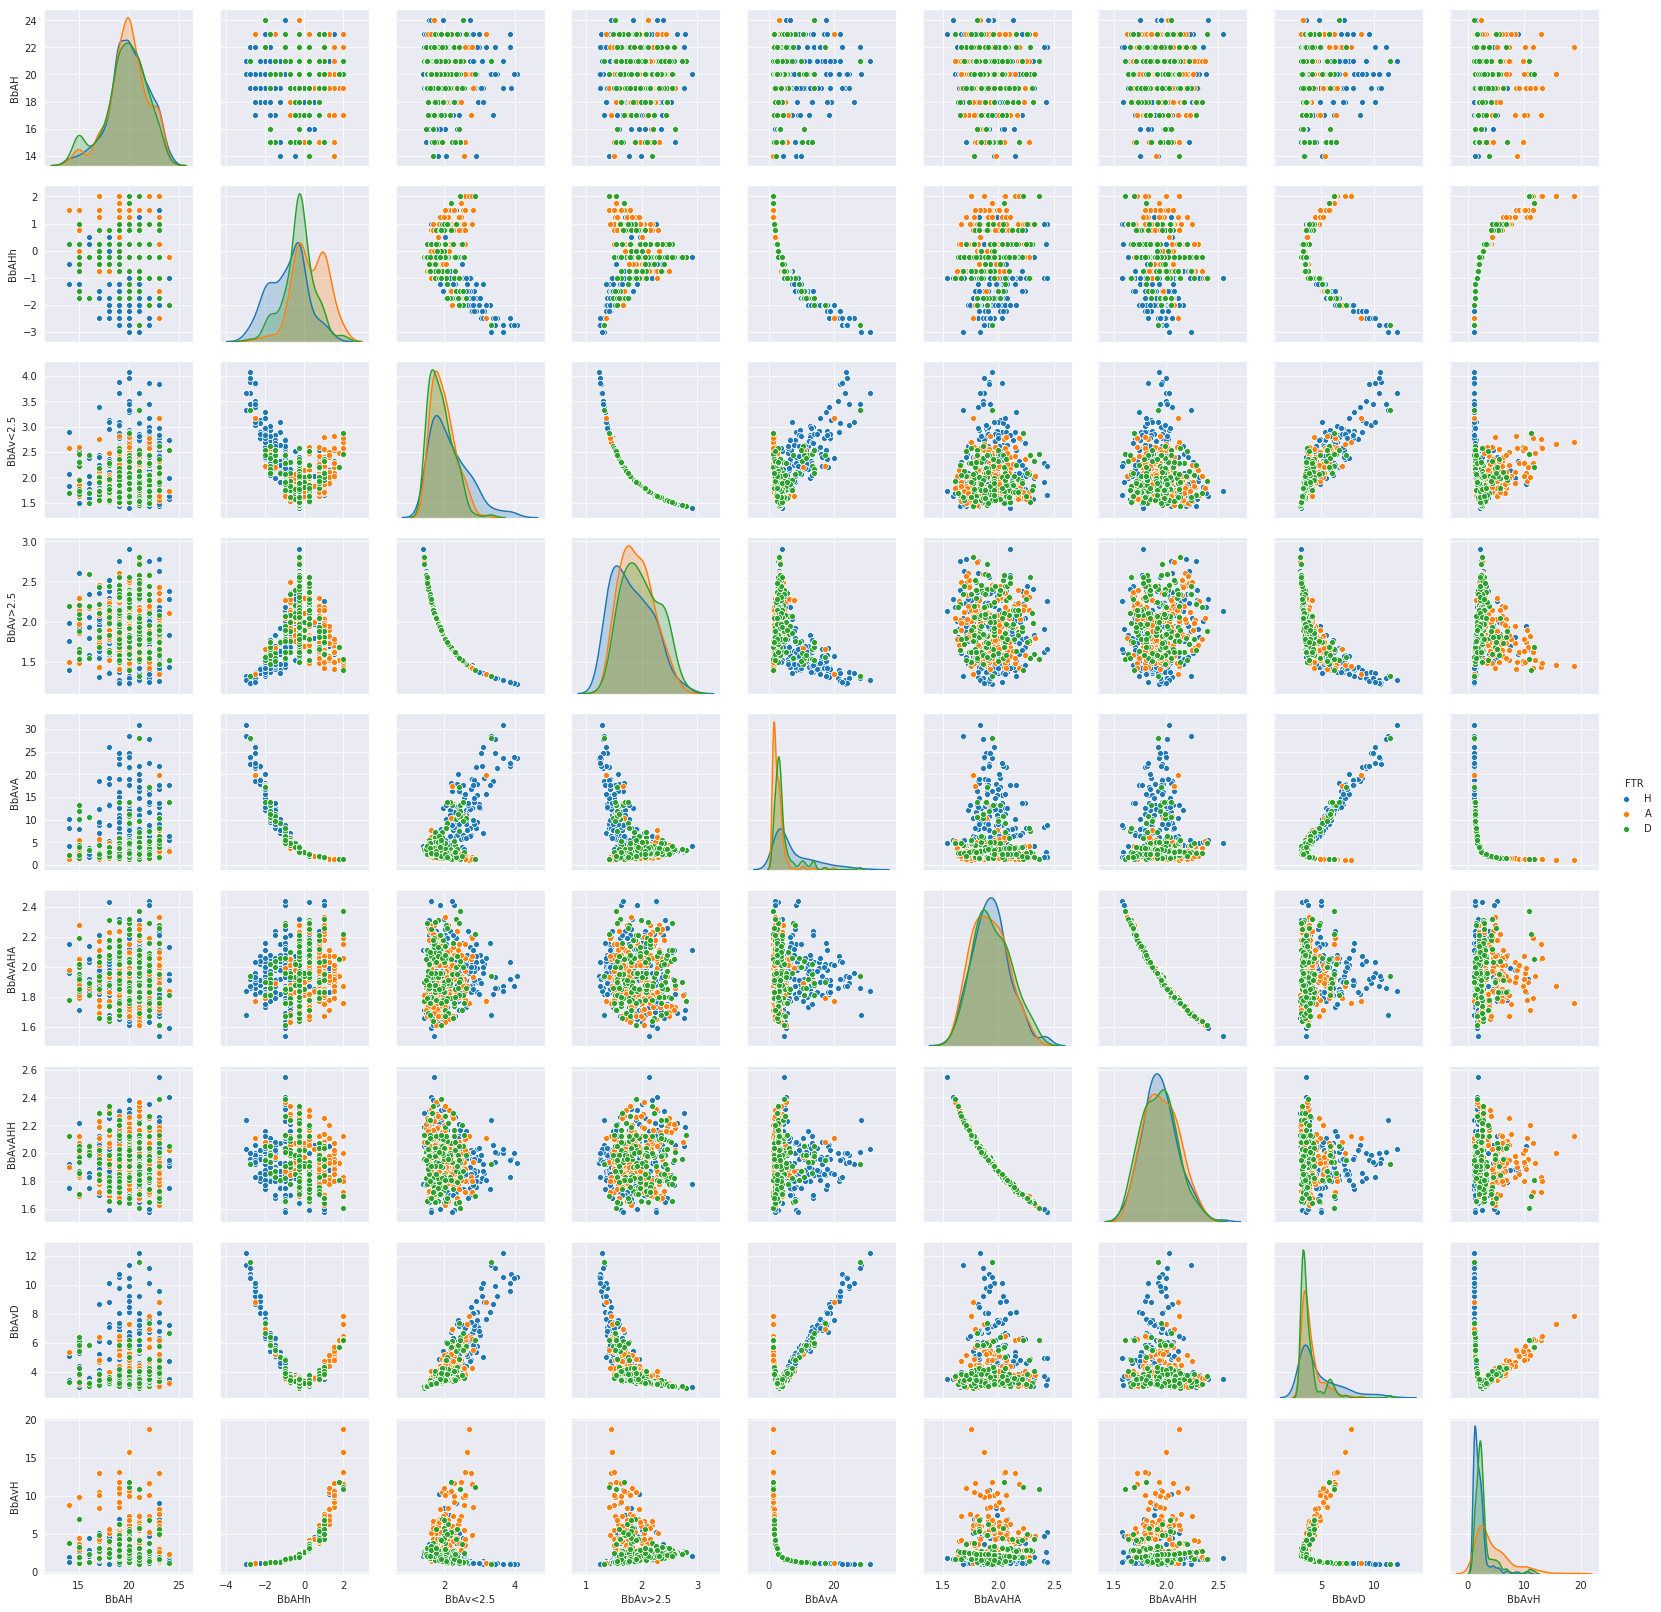

In [8]:
sns.set_style("darkgrid")
sns.pairplot(df[[x for x in list(df) if re.match(r'BbA\w', x)]+["FTR"]], hue="FTR")

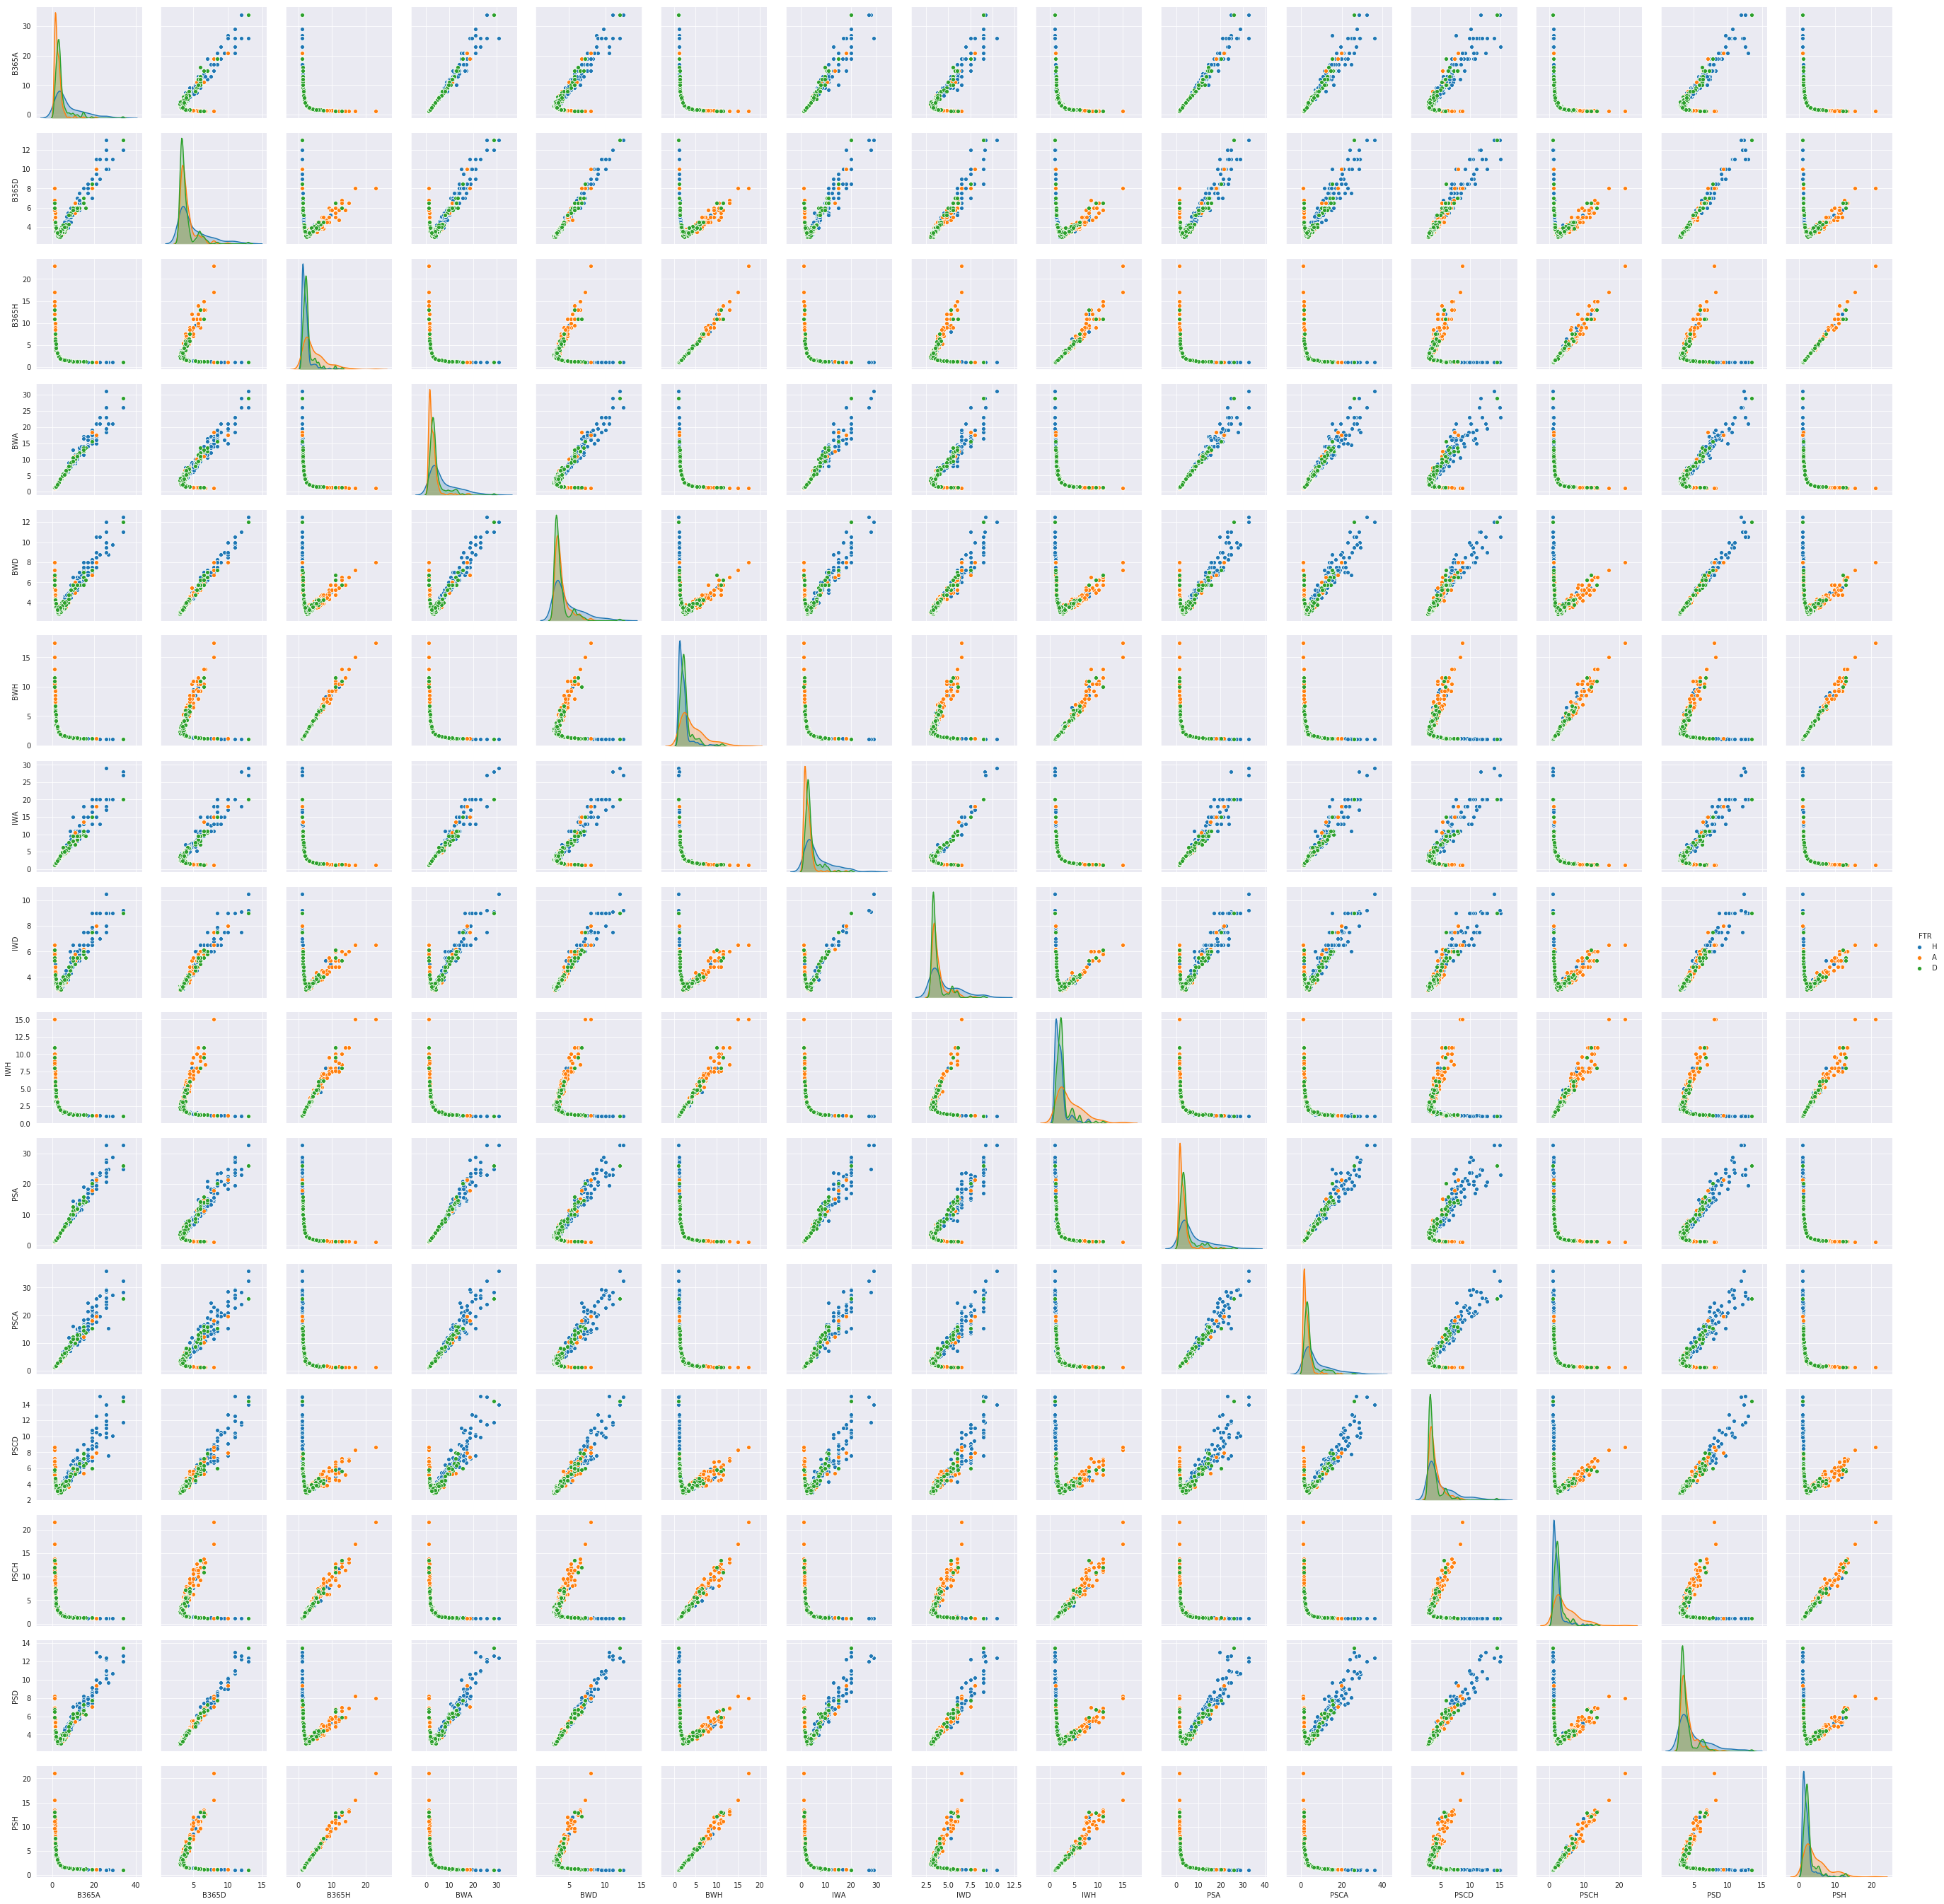

In [9]:
sns.pairplot(df[['B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH','IWA', 'IWD', 'IWH',
                 'PSA', 'PSCA', 'PSCD', 'PSCH', 'PSD', 'PSH', 'FTR']], hue="FTR")

<h3>We can see that most betting odds have a linear correlation when comparing outcome to outcome, dispersing a little more as the odds go up (which bookmakers tend to do to give the best price on an under dog).</h3>

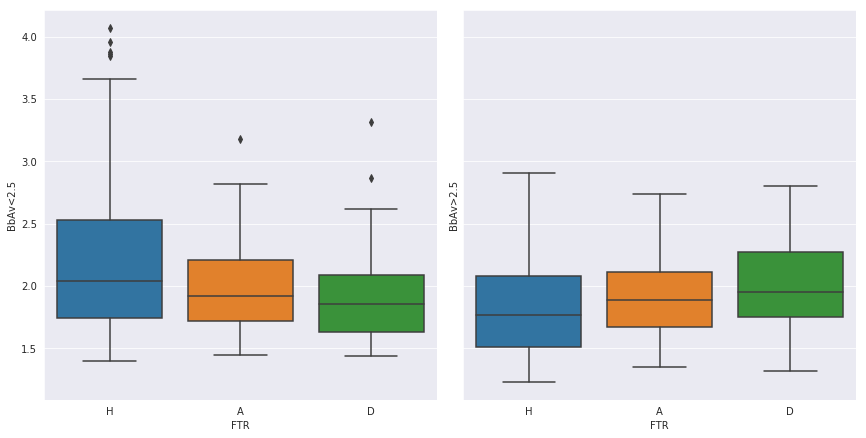

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12,6))
fig.tight_layout()
sns.catplot(y="BbAv<2.5", x="FTR", kind="box", data=df, ax=ax1)
sns.catplot(y="BbAv>2.5", x="FTR", kind="box", data=df, ax=ax2)
plt.close()
plt.close(2)

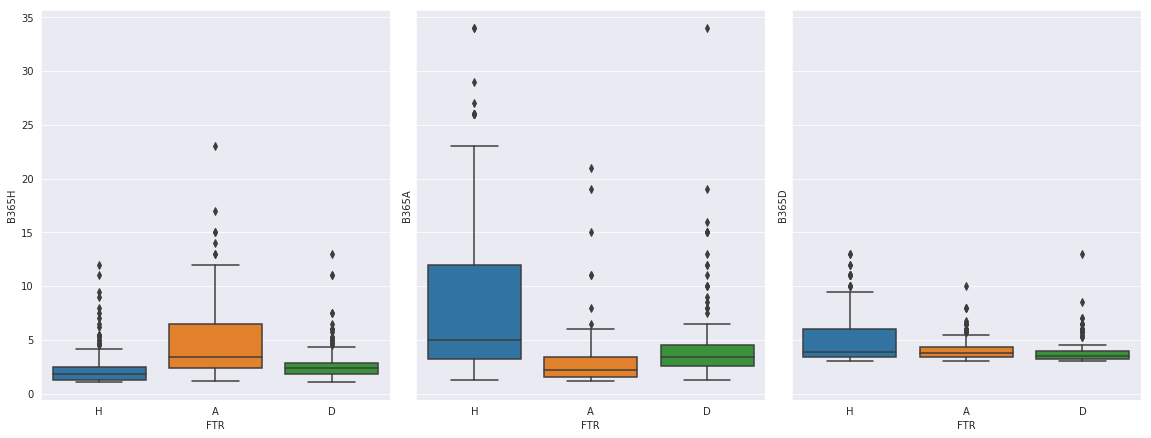

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(16,6))
fig.tight_layout()
sns.catplot(y="B365H", x="FTR", kind="box", data=df, ax=ax1)
sns.catplot(y="B365A", x="FTR", kind="box", data=df, ax=ax2)
sns.catplot(y="B365D", x="FTR", kind="box", data=df, ax=ax3)
plt.close()
plt.close(2)
plt.close(3)
plt.show()

In [12]:
set(list(df['AwayTeam']) + list(df['HomeTeam']))

{'Arsenal',
 'Bournemouth',
 'Brighton',
 'Burnley',
 'Cardiff',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Fulham',
 'Huddersfield',
 'Leicester',
 'Liverpool',
 'Man City',
 'Man United',
 'Newcastle',
 'Southampton',
 'Stoke',
 'Swansea',
 'Tottenham',
 'Watford',
 'West Brom',
 'West Ham',
 'Wolves'}

In [13]:
#Not ideal but we are going to replace last seasons religates to this seasons promoted teams.
df.AwayTeam.replace(['Swansea', 'Stoke', 'West Brom'], ['Wolves','Fulham', 'Cardiff'], inplace=True)
df.HomeTeam.replace(['Swansea', 'Stoke', 'West Brom'], ['Wolves','Fulham', 'Cardiff'], inplace=True)
set(list(df['AwayTeam']) + list(df['HomeTeam']))

{'Arsenal',
 'Bournemouth',
 'Brighton',
 'Burnley',
 'Cardiff',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Fulham',
 'Huddersfield',
 'Leicester',
 'Liverpool',
 'Man City',
 'Man United',
 'Newcastle',
 'Southampton',
 'Tottenham',
 'Watford',
 'West Ham',
 'Wolves'}

<h3>Now let's do some feature engineering and try to extract some valuable insights from our data to help our model. To do this I'm going to focus these features around team performance metrics based on the simple information that we are given, mainly trying to identify patterns or trends in results that can be associated with form and help predict the teams performance in their next match.</h3>

In [14]:
# A simple binary feature to flag if a team won their previous match
won_last = defaultdict(int)

df["HomeLastWin"] = False
df["VisitorLastWin"] = False

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeLastWin"] = 1 if won_last[home_team] else 0
    row["VisitorLastWin"] = 1 if won_last[visitor_team] else 0
    df.loc[index] = row

    won_last[home_team] = row["FTR"] == 'H'
    won_last[visitor_team] = row["FTR"] == 'A'

In [15]:
#teams that lead at half time and lost last match, sign of fatigue?
half_lead_lost_last = defaultdict(int)

df["HmLasthlll"] = False
df["VisLasthlll"] = False

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HmLasthlll"] = 1 if half_lead_lost_last[home_team] else 0
    row["VisLasthlll"] = 1 if half_lead_lost_last[visitor_team] else 0
    df.loc[index] = row

    half_lead_lost_last[home_team] = row["HTR"] == 'H' and row["FTR"] == 'A'
    half_lead_lost_last[visitor_team] = row["HTR"] == 'A' and row["FTR"] == 'H'

In [16]:
#teams that were down and came back to win.
half_down_win_last = defaultdict(int)

df["Hmdwl"] = False
df["Visdwl"] = False

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["Hmdwl"] = 1 if half_down_win_last[home_team] else 0
    row["Visdwl"] = 1 if half_down_win_last[visitor_team] else 0
    df.loc[index] = row

    half_down_win_last[home_team] = row["HTR"] == 'A' and row["FTR"] == 'H'
    half_down_win_last[visitor_team] = row["HTR"] == 'H' and row["FTR"] == 'A'

In [17]:
# Team win streaks.
df["HomeWinStreak"] = 0
df["VisitorWinStreak"] = 0

win_streak = defaultdict(int)

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeWinStreak"] = win_streak[home_team]
    row["VisitorWinStreak"] = win_streak[visitor_team]
    df.loc[index] = row

    if row["FTR"] == 'A':
        win_streak[home_team] = 0
        win_streak[visitor_team] += 1
    elif row["FTR"] == 'H':
        win_streak[home_team] += 1
        win_streak[visitor_team] = 0
    elif row["FTR"] == 'D':
        win_streak[home_team] = 0
        win_streak[visitor_team] = 0

In [18]:
#Team unbeaten streaks (win or draw).
df["HomeUnbeatenStreak"] = 0
df["VisitorUnbeatenStreak"] = 0

streak = defaultdict(int)

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeUnbeatenStreak"] = streak[home_team]
    row["VisitorUnbeatenStreak"] = streak[visitor_team]
    df.loc[index] = row

    if row["FTR"] == 'H':
        streak[home_team] += 1
        streak[visitor_team] = 0
    elif row["FTR"] == 'A':
        streak[home_team] = 0
        streak[visitor_team] += 1
    elif row["FTR"] == 'D':
        streak[home_team] += 1
        streak[visitor_team] += 1

In [19]:
# Team losing streaks
df["HomeLosingStreak"] = 0
df["VisitorLosingStreak"] = 0

losing_streak = defaultdict(int)

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeLosingStreak"] = losing_streak[home_team]
    row["VisitorLosingStreak"] = losing_streak[visitor_team]
    df.loc[index] = row

    if row["FTR"] == 'A':
        losing_streak[home_team] += 1
        losing_streak[visitor_team] = 0
    elif row["FTR"] == 'H':
        losing_streak[home_team] = 0
        losing_streak[visitor_team] += 1
    elif row["FTR"] == 'D':
        losing_streak[home_team] = 0
        losing_streak[visitor_team] = 0

In [20]:
last_match_stats = {x:{"prev_S":0,
"prev_ST":0,
"prev_C":0} for x in set(list(df['AwayTeam']) + list(df['HomeTeam']))}
# HS = Home Team Shots
# AS = Away Team Shots
# HST = Home Team Shots on Target
# AST = Away Team Shots on Target
# HC = Home Team Corners
# AC = Away Team Corners
 
df["prev_HS"] = 0
df["prev_AS"] = 0
df["prev_HST"] = 0
df["prev_AST"] = 0
df["prev_HC"] = 0
df["prev_AC"] = 0

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    away_team = row["AwayTeam"]
    row["prev_HS"] = last_match_stats[home_team]["prev_S"] if last_match_stats[home_team]["prev_S"] else 0
    row["prev_HST"] = last_match_stats[home_team]["prev_ST"] if last_match_stats[home_team]["prev_ST"] else 0
    row["prev_HC"] = last_match_stats[home_team]["prev_C"] if last_match_stats[home_team]["prev_C"] else 0
    row["prev_AS"] = last_match_stats[away_team]["prev_S"] if last_match_stats[away_team]["prev_S"] else 0
    row["prev_AST"] = last_match_stats[away_team]["prev_ST"] if last_match_stats[away_team]["prev_ST"] else 0
    row["prev_AC"] = last_match_stats[away_team]["prev_C"] if last_match_stats[away_team]["prev_C"] else 0
    df.loc[index] = row

    last_match_stats[home_team]["prev_S"] = row["HS"]    
    last_match_stats[home_team]["prev_ST"] = row["HST"]    
    last_match_stats[home_team]["prev_C"] = row["HC"]
    last_match_stats[away_team]["prev_S"] = row["AS"]
    last_match_stats[away_team]["prev_ST"] = row["AST"]
    last_match_stats[away_team]["prev_C"] = row["AC"]

In [21]:
df.HomeUnbeatenStreak.value_counts()

0     240
1     112
2      73
3      41
4      32
5      16
6      15
8       8
10      6
14      4
7       4
17      3
13      3
11      3
9       2
19      2
12      2
16      1
18      1
21      1
Name: HomeUnbeatenStreak, dtype: int64

In [22]:
df.HomeLosingStreak.value_counts()

0    339
1    123
2     62
3     27
4     10
5      4
7      2
8      1
6      1
Name: HomeLosingStreak, dtype: int64

In [23]:
man_city = df[(df['HomeTeam'] == 'Man City') | (df['AwayTeam'] == 'Man City')]
man_city[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
          'HomeUnbeatenStreak','VisitorUnbeatenStreak', 'HomeLosingStreak','VisitorLosingStreak']]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomeUnbeatenStreak,VisitorUnbeatenStreak,HomeLosingStreak,VisitorLosingStreak
1,12/08/17,Brighton,Man City,0,2,A,0,0,0,0
19,21/08/17,Man City,Everton,1,1,D,1,1,0,0
20,26/08/17,Bournemouth,Man City,1,2,A,0,2,2,0
34,09/09/17,Man City,Liverpool,5,0,H,3,3,0,0
46,16/09/17,Watford,Man City,0,6,A,4,4,0,0
53,23/09/17,Man City,Crystal Palace,5,0,H,5,0,0,5
61,30/09/17,Chelsea,Man City,0,1,A,5,6,0,0
73,14/10/17,Man City,Fulham,7,2,H,7,1,0,0
83,21/10/17,Man City,Burnley,3,0,H,8,6,0,0
96,28/10/17,Cardiff,Man City,2,3,A,0,9,1,0


In [24]:
df.columns

Index(['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'AwayTeam', 'B365A', 'B365D',
       'B365H', 'BWA', 'BWD', 'BWH', 'Bb1X2', 'BbAH', 'BbAHh', 'BbAv<2.5',
       'BbAv>2.5', 'BbAvA', 'BbAvAHA', 'BbAvAHH', 'BbAvD', 'BbAvH', 'BbMx<2.5',
       'BbMx>2.5', 'BbMxA', 'BbMxAHA', 'BbMxAHH', 'BbMxD', 'BbMxH', 'BbOU',
       'Date', 'Div', 'FTAG', 'FTHG', 'FTR', 'HC', 'HF', 'HR', 'HS', 'HST',
       'HTAG', 'HTHG', 'HTR', 'HY', 'HomeTeam', 'IWA', 'IWD', 'IWH', 'PSA',
       'PSCA', 'PSCD', 'PSCH', 'PSD', 'PSH', 'Referee', 'VCA', 'VCD', 'VCH',
       'WHA', 'WHD', 'WHH', 'HomeLastWin', 'VisitorLastWin', 'HmLasthlll',
       'VisLasthlll', 'Hmdwl', 'Visdwl', 'HomeWinStreak', 'VisitorWinStreak',
       'HomeUnbeatenStreak', 'VisitorUnbeatenStreak', 'HomeLosingStreak',
       'VisitorLosingStreak', 'prev_HS', 'prev_AS', 'prev_HST', 'prev_AST',
       'prev_HC', 'prev_AC'],
      dtype='object')

In [25]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["HomeTeam_Enc"] = lb_make.fit_transform(df["HomeTeam"])
df["AwayTeam_Enc"] = lb_make.fit_transform(df["AwayTeam"])
df[["HomeTeam", "HomeTeam_Enc", "AwayTeam", "AwayTeam_Enc"]].head(21)

,HomeTeam,HomeTeam_Enc,AwayTeam,AwayTeam_Enc
0,Arsenal,0,Leicester,10
1,Brighton,2,Man City,12
2,Chelsea,5,Burnley,3
3,Crystal Palace,6,Huddersfield,9
4,Everton,7,Fulham,8
5,Southampton,15,Wolves,19
6,Watford,17,Liverpool,11
7,Cardiff,4,Bournemouth,1
8,Man United,13,West Ham,18
9,Newcastle,14,Tottenham,16


In [26]:
df["target"] = [1 if x == 'H' else 0 for x in list(df["FTR"])]

In [27]:
X = df.drop(['Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'HS', 'AS', 'HST', 
         'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR',"Div", "Date", "FTHG", "HomeTeam", "AwayTeam",
         'FTAG','FTR','HTHG','HTAG','HTR'], axis=1).reset_index(drop=True)
X.columns

Index(['B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'Bb1X2', 'BbAH',
       'BbAHh', 'BbAv<2.5', 'BbAv>2.5', 'BbAvA', 'BbAvAHA', 'BbAvAHH', 'BbAvD',
       'BbAvH', 'BbMx<2.5', 'BbMx>2.5', 'BbMxA', 'BbMxAHA', 'BbMxAHH', 'BbMxD',
       'BbMxH', 'BbOU', 'IWA', 'IWD', 'IWH', 'PSA', 'PSCA', 'PSCD', 'PSCH',
       'PSD', 'PSH', 'VCA', 'VCD', 'VCH', 'WHA', 'WHD', 'WHH', 'HomeLastWin',
       'VisitorLastWin', 'HmLasthlll', 'VisLasthlll', 'Hmdwl', 'Visdwl',
       'HomeWinStreak', 'VisitorWinStreak', 'HomeUnbeatenStreak',
       'VisitorUnbeatenStreak', 'HomeLosingStreak', 'VisitorLosingStreak',
       'prev_HS', 'prev_AS', 'prev_HST', 'prev_AST', 'prev_HC', 'prev_AC',
       'HomeTeam_Enc', 'AwayTeam_Enc', 'target'],
      dtype='object')

In [28]:
X.isnull().values.any()

False

Text(0, 0.5, 'Cumulative Explained Variance')

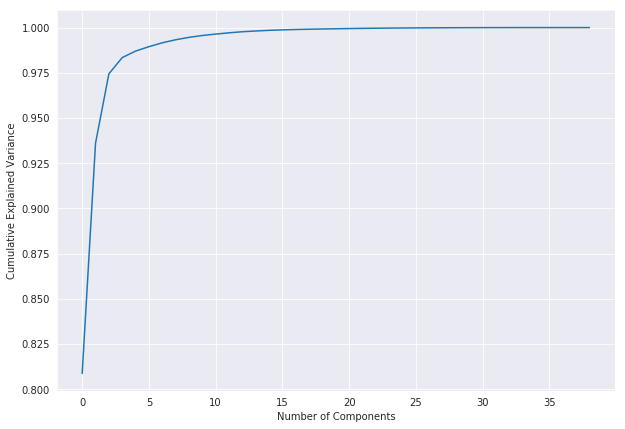

In [29]:
X = X.fillna(0)
pca_features = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
               'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH',#'LBH', 'LBD', 'LBA', 
               'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA',
               'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5', 'BbAv<2.5', 'BbAH',
               'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'PSCH', 'PSCD',
               'PSCA']

pca = PCA().fit(X[pca_features])

sns.set_style("darkgrid")
plt.figure(figsize=(10, 7))
ax = sns.lineplot(data=np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [30]:
pca = PCA(n_components=12)
principalComponents = pca.fit_transform(X[pca_features])
pdf = pd.DataFrame(data = principalComponents)
pdf.columns = ['pc_'+str(x) for x in list(pdf)]
pdf.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11
0,4.124768,-4.055050,-4.071446,-0.227043,-1.291100,-0.709952,0.587661,-0.194658,-0.356517,0.263279,0.722993,-0.508792
1,-16.153835,20.118243,-2.184916,0.474701,-0.692013,-0.309834,-0.904178,0.301958,-0.278609,0.318791,0.000165,0.064116
2,26.301103,-0.396891,-3.914846,1.090594,-0.715137,1.676096,-2.269015,-1.717175,-0.097160,-0.087405,0.100163,-1.538766
3,-1.508275,-4.897451,-2.397114,2.329814,-1.235719,-0.763390,-1.265117,0.823163,-0.436682,0.291297,0.007755,-0.204956
4,0.490411,-4.723266,-1.358198,1.095163,-1.122963,0.016147,-1.350842,0.309177,-0.269953,0.185608,0.068471,-0.066788


In [31]:
pdf.shape

(569, 12)

In [32]:
pdf = pdf.join(X[[x for x in list(X) if x not in pca_features]])
pdf.shape

(569, 33)

In [33]:
Y = pdf['target']
X = pdf[[x for x in pdf.columns if x != 'target']]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(426, 32)
(143, 32)
(426,)
(143,)


In [35]:
X_train.isnull().values.any()

False

Train score: 0.728
Test score: 0.643
Test precision: 0.639
Test recall: 0.574
Test f1: 0.605


/home/srooney/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(91.68, 0.5, 'actual label')

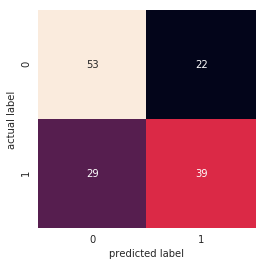

In [36]:
lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)

lr_y_pred = lr_clf.predict(X_test)

print(f"Train score: {round(lr_clf.score(X_train, y_train), 3)}")
print(f"Test score: {round(lr_clf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, lr_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, lr_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, lr_y_pred), 3)}")

confmatrix = confusion_matrix(y_test, lr_y_pred)

sns.heatmap(confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [37]:
eli5.show_weights(lr_clf, feature_names=list(X_train))

In [38]:
clf_rf = RandomForestClassifier(random_state=12, n_jobs=-1)
param_dist = {'bootstrap': [True, False],
             'n_estimators': stats.randint(100, 2000),
             'criterion': ['gini', 'entropy'],
             'max_depth': stats.randint(1, 150),
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': stats.randint(1, 100),
             'min_samples_split': stats.randint(1, 100),
             'max_leaf_nodes': stats.randint(1, 100)
             }

rf_rndm = RandomizedSearchCV(clf_rf, param_distributions = param_dist,
                         cv = 5, random_state = 12, n_iter = 300,
                         scoring = 'roc_auc', error_score = 0, 
                         verbose = 3, n_jobs = -1)

rf_rndm.fit(X_train, y_train)
print("Score: {}".format(rf_rndm.best_score_))
print(rf_rndm.best_estimator_)
print(rf_rndm.best_params_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  8.9min finished


Score: 0.7267234112651522
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=103, max_features='sqrt', max_leaf_nodes=5,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=325, n_jobs=-1,
            oob_score=False, random_state=12, verbose=0, warm_start=False)
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 103, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 325}


Train score: 0.718
Test score: 0.72
Test precision: 0.741
Test recall: 0.632
Test f1: 0.683


Text(91.68, 0.5, 'actual label')

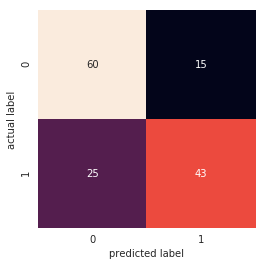

In [39]:
rf_clf = rf_rndm.best_estimator_
rf_clf.fit(X_train, y_train)

rf_y_pred = rf_clf.predict(X_test)

print(f"Train score: {round(rf_clf.score(X_train, y_train), 3)}")
print(f"Test score: {round(rf_clf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, rf_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, rf_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, rf_y_pred), 3)}")
      
rf_confmatrix = confusion_matrix(y_test, rf_y_pred)

sns.heatmap(rf_confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [40]:
eli5.show_weights(rf_clf, feature_names=list(X_train))

Weight,Feature
0.3213 ± 0.6244,pc_0
0.1109 ± 0.3513,pc_5
0.0938 ± 0.3172,pc_10
0.0675 ± 0.2447,VisitorWinStreak
0.0495 ± 0.2206,VisitorLastWin
0.0495 ± 0.2060,HomeUnbeatenStreak
0.0465 ± 0.1935,pc_4
0.0400 ± 0.1855,pc_11
0.0380 ± 0.1574,pc_1
0.0370 ± 0.1820,pc_7


In [41]:
perm = PermutationImportance(rf_clf).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=[x for x in pdf.columns if x != 'target'])

Weight,Feature
0.0615 ± 0.0459,pc_0
0.0075 ± 0.0182,pc_5
0.0047 ± 0.0084,VisitorLastWin
0.0042 ± 0.0055,HomeWinStreak
0.0033 ± 0.0076,VisitorWinStreak
0.0023 ± 0.0030,pc_1
0.0014 ± 0.0048,pc_7
0.0014 ± 0.0023,pc_3
0.0014 ± 0.0038,pc_4
0.0005 ± 0.0081,pc_10


In [42]:
scorer = make_scorer(f1_score)

clf_xgb = XGBClassifier(objective = 'binary:logistic', n_jobs=-1, random_state=12)
param_dist = {'n_estimators': stats.randint(100, 2000),
              'booster': ['gbtree', 'dart'],
              'learning_rate': stats.uniform(0.0001, 0.1),
              'gamma':stats.uniform(0.001, 10),
              'subsample': stats.uniform(0.1, 0.9),
              'max_depth': stats.randint(1, 150),
              'max_bin': stats.randint(4, 1000),
              'colsample_bytree': stats.uniform(0.1, 0.9),
              'min_child_weight': stats.randint(1, 100),
              'reg_alpha': stats.randint(2, 150),
              'reg_lambda': stats.randint(2, 150)
             }

xg_rndm = RandomizedSearchCV(clf_xgb, param_distributions = param_dist,
                         cv = 5, random_state = 12, n_iter = 500,
                         scoring = scorer, verbose = 3, n_jobs = -1)

xg_rndm.fit(X_train, y_train)
print("Score: {}".format(xg_rndm.best_score_))
print(xg_rndm.best_estimator_)
print(xg_rndm.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 12.3min finished
/home/srooney/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Score: 0.6324845202080651
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8678834656054557, gamma=0.7247398904404924,
       learning_rate=0.003765298283429308, max_bin=743, max_delta_step=0,
       max_depth=36, min_child_weight=14, missing=None, n_estimators=1869,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=12, reg_alpha=3, reg_lambda=59, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.3482952394248854)
{'booster': 'gbtree', 'colsample_bytree': 0.8678834656054557, 'gamma': 0.7247398904404924, 'learning_rate': 0.003765298283429308, 'max_bin': 743, 'max_depth': 36, 'min_child_weight': 14, 'n_estimators': 1869, 'reg_alpha': 3, 'reg_lambda': 59, 'subsample': 0.3482952394248854}


Train score: 0.69
Test score: 0.699
Test precision: 0.692
Test recall: 0.662
Test f1: 0.677


Text(91.68, 0.5, 'actual label')

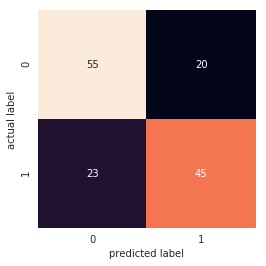

In [43]:
xg_clf = xg_rndm.best_estimator_

xg_clf.fit(X_train, y_train)

xg_y_pred = xg_clf.predict(X_test)

print(f"Train score: {round(xg_clf.score(X_train, y_train), 3)}")
print(f"Test score: {round(xg_clf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, xg_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, xg_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, xg_y_pred), 3)}")

confmatrix = confusion_matrix(y_test, xg_y_pred)

sns.heatmap(confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [44]:
eli5.explain_weights_xgboost(xg_clf)

Weight,Feature
0.0680,pc_0
0.0468,VisitorUnbeatenStreak
0.0461,prev_HST
0.0451,VisitorWinStreak
0.0446,HomeTeam_Enc
0.0441,prev_HS
0.0420,VisitorLastWin
0.0417,pc_10
0.0410,prev_AS
0.0410,HomeUnbeatenStreak


In [45]:
scorer = make_scorer(f1_score)

params ={'n_estimators': stats.randint(1, 5000),
         'learning_rate': [0.005, 0.01, 0.1, 1],
         'num_iterations': stats.randint(1, 5000),
             'boosting_type':['gbdt', 'dart'],
             'max_depth': stats.randint(-1, 150),
             'max_bin': stats.randint(4, 500),
             'num_leaves': stats.randint(3, 200), 
             'min_child_samples': stats.randint(1, 500),
             'min_child_weight': stats.randint(0, 50),
             'subsample': stats.uniform(loc=0.2, scale=0.8),
             'colsample_bytree' : [0.65, 0.66, 0.8, 0.9],
             'reg_alpha': stats.randint(2, 200),
             'reg_lambda': stats.randint(2, 200)
            }

clf_lgbm = lgbm.LGBMClassifier(random_state=12, objective='binary',silent=True, 
                          metric='binary_error', n_jobs=-1)

lgbm_rndm = RandomizedSearchCV(clf_lgbm, param_distributions=params, 
                            n_iter=2000, scoring=scorer, cv=5,
                            refit=True, random_state=12,verbose=1,n_jobs=-1)

lgbm_rndm.fit(X_train, y_train)
print("Score: {}".format(lgbm_rndm.best_score_))
print(lgbm_rndm.best_estimator_)
print(lgbm_rndm.best_params_)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 891 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 1430 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 1980 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2630 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3380 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4230 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 5180 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 6230 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 7380 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 8630 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  5.4min finished
/home/srooney/.local/lib/python3.

Score: 0.6457735173104434
LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=0.9,
        importance_type='split', learning_rate=0.1, max_bin=414,
        max_depth=36, metric='binary_error', min_child_samples=66,
        min_child_weight=41, min_split_gain=0.0, n_estimators=1021,
        n_jobs=-1, num_iterations=2953, num_leaves=129, objective='binary',
        random_state=12, reg_alpha=11, reg_lambda=192, silent=True,
        subsample=0.5171092807101166, subsample_for_bin=200000,
        subsample_freq=0)
{'boosting_type': 'dart', 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_bin': 414, 'max_depth': 36, 'min_child_samples': 66, 'min_child_weight': 41, 'n_estimators': 1021, 'num_iterations': 2953, 'num_leaves': 129, 'reg_alpha': 11, 'reg_lambda': 192, 'subsample': 0.5171092807101166}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train score: 0.716
Test score: 0.741
Test precision: 0.746
Test recall: 0.691
Test f1: 0.718


Text(91.68, 0.5, 'actual label')

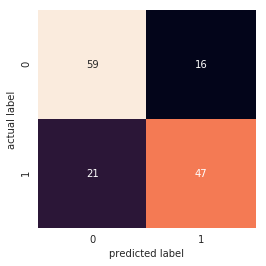

In [46]:
#lgbm_clf = lgbm_grid.best_estimator_
lgbm_clf =lgbm.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
        importance_type='split', learning_rate=0.005, max_bin=187,
        max_depth=96, metric='binary_error', min_child_samples=89,
        min_child_weight=0.01, min_split_gain=0.0, n_estimators=4552,
        n_jobs=-1, num_iterations=3873, num_leaves=19, objective='binary',
        random_state=2, reg_alpha=2, reg_lambda=150, silent=True,
        subsample=0.44499918414335005, subsample_for_bin=200000,
        subsample_freq=0)


lgbm_clf.fit(X_train, y_train)

lgbm_y_pred = lgbm_clf.predict(X_test)

print(f"Train score: {round(lgbm_clf.score(X_train, y_train), 3)}")
print(f"Test score: {round(lgbm_clf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, lgbm_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, lgbm_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, lgbm_y_pred), 3)}")

%matplotlib inline

confmatrix = confusion_matrix(y_test, lgbm_y_pred)

sns.heatmap(confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [47]:
from eli5.lightgbm import explain_weights_lightgbm
explain_weights_lightgbm(lgbm_clf)

Weight,Feature
0.7524,pc_0
0.0623,VisitorLastWin
0.0392,pc_1
0.0387,prev_HS
0.0307,pc_3
0.0269,HomeUnbeatenStreak
0.0163,pc_10
0.0104,pc_5
0.0098,pc_11
0.0038,VisitorWinStreak


In [48]:
svc = SVC(probability=True)
import scipy

parameter_space = {'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
  'kernel': ['rbf', 'poly', 'linear'], 'degree': stats.randint(1, 10),'class_weight':['balanced', None]}

svc_rndm = RandomizedSearchCV(svc, param_distributions=parameter_space, 
                            n_iter=20, scoring=scorer, cv=5,
                            refit=True, random_state=12,verbose=1,n_jobs=-1)

svc_rndm.fit(X_train, y_train)
print("Score: {0: .4f}".format(svc_rndm.best_score_))
print(svc_rndm.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.9min finished
/home/srooney/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Score:  0.5987
SVC(C=155.79204028883595, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma=0.13377450577858419,
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


Train score: 0.723
Test score: 0.622
Test precision: 0.613
Test recall: 0.559
Test f1: 0.585


Text(91.68, 0.5, 'actual label')

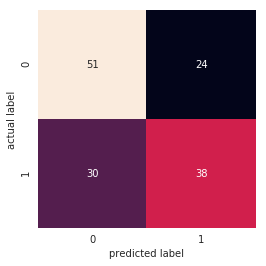

In [49]:
svc_clf = svc_rndm.best_estimator_
svc_clf.fit(X_train, y_train)

svc_y_pred = svc_clf.predict(X_test)

print(f"Train score: {round(svc_clf.score(X_train, y_train), 3)}")
print(f"Test score: {round(svc_clf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, svc_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, svc_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, svc_y_pred), 3)}")

%matplotlib inline

confmatrix = confusion_matrix(y_test, svc_y_pred)

sns.heatmap(confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [50]:
eli5.show_weights(svc_clf, feature_names=list(X_train))

Train score: 0.709
Test score: 0.734
Test precision: 0.759
Test recall: 0.647
Test f1: 0.698


Text(91.68, 0.5, 'actual label')

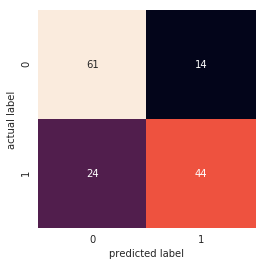

In [51]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('lg', lgbm_clf), ('xg', xg_clf), ('rf', rf_clf)],
                         voting='hard', n_jobs=-1)

eclf = eclf.fit(X_train, y_train)

e_y_pred = eclf.predict(X_test)

print(f"Train score: {round(eclf.score(X_train, y_train), 3)}")
print(f"Test score: {round(eclf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, e_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, e_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, e_y_pred), 3)}")

%matplotlib inline

confmatrix = confusion_matrix(y_test, e_y_pred)

sns.heatmap(confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [59]:
xpbs = X.copy()

In [62]:
rf_probs = rf_clf.predict_proba(X)
rf_probs = [x[1] for x in rf_probs]
xgprobs = xg_clf.predict_proba(X)
xgprobs = [x[1] for x in xgprobs]
lgbmprobs = lgbm_clf.predict_proba(X)
lgbmprobs = [x[1] for x in lgbmprobs]
epreds = eclf.predict(X)
xpbs["xg_probs"] = xgprobs
xpbs["rf_probs"] = rf_probs
xpbs["lgbm_probs"] = lgbmprobs
xpbs["ens_preds"] = epreds
xpbs["HomeTeam"] = lb_make.inverse_transform(xpbs["HomeTeam_Enc"])
xpbs["AwayTeam"] = lb_make.inverse_transform(xpbs["AwayTeam_Enc"])
xpbs["actual"] = y_test
xpbs[[x for x in list(xpbs) if 'pc_' not in x]]

,HomeLastWin,VisitorLastWin,HmLasthlll,VisLasthlll,Hmdwl,Visdwl,HomeWinStreak,VisitorWinStreak,HomeUnbeatenStreak,VisitorUnbeatenStreak,...,prev_AC,HomeTeam_Enc,AwayTeam_Enc,xg_probs,rf_probs,lgbm_probs,ens_preds,HomeTeam,AwayTeam,actual
0,0,0,0,0,0,0,0,0,0,0,...,0,0,10,0.584713,0.689302,0.691690,1,Arsenal,Leicester,NaN
1,0,0,0,0,0,0,0,0,0,0,...,0,2,12,0.364852,0.333465,0.272244,0,Brighton,Man City,NaN
2,0,0,0,0,0,0,0,0,0,0,...,0,5,3,0.579915,0.576341,0.639241,1,Chelsea,Burnley,NaN
3,0,0,0,0,0,0,0,0,0,0,...,0,6,9,0.579348,0.662712,0.507926,1,Crystal Palace,Huddersfield,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,7,8,0.579625,0.554344,0.562680,1,Everton,Fulham,NaN
5,0,0,0,0,0,0,0,0,0,0,...,0,15,19,0.578876,0.562179,0.588284,1,Southampton,Wolves,NaN
6,0,0,0,0,0,0,0,0,0,0,...,0,17,11,0.357217,0.320287,0.289033,0,Watford,Liverpool,NaN
7,0,0,0,0,0,0,0,0,0,0,...,0,4,1,0.375625,0.397844,0.395829,0,Cardiff,Bournemouth,1.0
8,0,0,0,0,0,0,0,0,0,0,...,0,13,18,0.579022,0.583643,0.663233,1,Man United,West Ham,NaN
9,0,0,0,0,0,0,0,0,0,0,...,0,14,16,0.352084,0.325997,0.248472,0,Newcastle,Tottenham,NaN


In [63]:
xpbs.loc[(xpbs['ens_preds'] == 1) & (xpbs['actual'] == 1)]

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,prev_AC,HomeTeam_Enc,AwayTeam_Enc,xg_probs,rf_probs,lgbm_probs,ens_preds,HomeTeam,AwayTeam,actual
12,-0.281760,-4.620030,3.731739,2.172010,0.728565,0.345478,0.263639,-0.023738,-0.186055,-0.038577,...,3,10,2,0.564696,0.515745,0.541986,1,Leicester,Brighton,1.0
34,-3.416779,-4.153184,7.925907,2.818724,-1.719668,-0.428421,0.540772,-0.091440,0.588800,-0.368357,...,4,12,11,0.569826,0.513214,0.559052,1,Man City,Liverpool,1.0
51,0.398425,-4.684297,-1.244374,2.241321,-0.562734,0.173241,-0.040411,-0.223230,-0.226793,0.131905,...,6,7,1,0.564177,0.509429,0.522379,1,Everton,Bournemouth,1.0
53,45.858308,5.341813,0.327053,2.046466,-3.065200,-1.968551,-0.015813,-0.004828,-0.664674,-0.754427,...,5,12,6,0.582221,0.781847,0.760356,1,Man City,Crystal Palace,1.0
66,-2.562559,-4.815682,1.211389,2.549670,-0.631829,-0.481517,-0.609317,0.273638,-0.070381,0.215160,...,5,18,19,0.575247,0.553360,0.542964,1,West Ham,Wolves,1.0
75,26.328937,1.297812,6.885240,0.345767,-2.500930,2.840519,1.349143,0.092685,1.177310,-0.213233,...,7,16,1,0.590306,0.672646,0.735000,1,Tottenham,Bournemouth,1.0
84,-3.510347,-4.457416,4.212880,-0.295184,-0.680655,-0.472310,-0.599751,0.135113,-0.335937,0.270399,...,5,14,6,0.562392,0.431415,0.549514,1,Newcastle,Crystal Palace,1.0
90,24.366745,0.750724,5.942031,-1.554307,-1.336594,-2.259589,1.160386,0.687145,-0.503947,-1.080732,...,7,0,19,0.580858,0.748748,0.769657,1,Arsenal,Wolves,1.0
111,-1.408171,-4.448457,5.518883,-0.562751,-0.122177,0.032208,-1.044000,0.827779,0.049108,0.189442,...,3,1,9,0.569994,0.491902,0.512674,1,Bournemouth,Huddersfield,1.0
116,23.655519,-0.898957,3.206735,0.597285,2.361807,-0.134176,-0.685709,1.556234,-0.977515,-0.034500,...,11,13,14,0.577614,0.611688,0.683441,1,Man United,Newcastle,1.0


In [64]:
xpbs[['HomeTeam', 'xg_probs', 'rf_probs', 'lgbm_probs']].groupby('HomeTeam').describe()

lgbm_probs                                                    \
                    count      mean       std       min       25%       50%   
HomeTeam                                                                      
Arsenal              29.0  0.606407  0.183596  0.222059  0.441627  0.685595   
Bournemouth          29.0  0.393323  0.136363  0.216465  0.268356  0.376791   
Brighton             28.0  0.327942  0.098676  0.200032  0.242628  0.316095   
Burnley              28.0  0.328589  0.100935  0.204867  0.244567  0.292886   
Cardiff              29.0  0.326058  0.092663  0.177223  0.244159  0.328516   
Chelsea              29.0  0.623399  0.159550  0.233182  0.522393  0.684005   
Crystal Palace       28.0  0.389960  0.145564  0.203253  0.241557  0.403276   
Everton              29.0  0.454146  0.179580  0.198273  0.248809  0.494866   
Fulham               28.0  0.350188  0.106225  0.204304  0.248058  0.344184   
Huddersfield         29.0  0.339247  0.099069  0.200032  0.247186  0.334711   
Leicester            28.0  0.424093  0.148969  0.196239  0.297278  0.426015   
Liverpool            28.0  0.642595  0.158423  0.247865  0.643311  0.704777   
Man City             29.0  0.715050  0.062224  0.498066  0.700955  0.726529   
Man United           28.0  0.623461  0.150558  0.223265  0.585224  0.674932   
Newcastle            29.0  0.372438  0.132840  0.204167  0.255970  0.359547   
Southampton          27.0  0.442285  0.160606  0.212336  0.290858  0.445281   
Tottenham            27.0  0.621431  0.161254  0.210308  0.517211  0.701194   
Watford              29.0  0.382523  0.145609  0.200922  0.248605  0.342730   
West Ham             29.0  0.379262  0.138975  0.191889  0.284658  0.319335   
Wolves               29.0  0.371303  0.162428  0.193486  0.227212  0.368009   

                                   rf_probs              ...               \
                     75%       max    count      mean    ...          75%   
HomeTeam                                                 ...                
Arsenal         0.731485  0.769657     29.0  0.589938    ...     0.703639   
Bournemouth     0.512674  0.611836     29.0  0.414011    ...     0.491902   
Brighton        0.369061  0.539356     28.0  0.346385    ...     0.389011   
Burnley         0.409436  0.510852     28.0  0.352782    ...     0.415717   
Cardiff         0.395829  0.506902     29.0  0.348220    ...     0.397378   
Chelsea         0.719000  0.769488     29.0  0.573023    ...     0.672911   
Crystal Palace  0.488631  0.699962     28.0  0.405085    ...     0.467874   
Everton         0.627856  0.747300     29.0  0.445107    ...     0.561285   
Fulham          0.434327  0.591079     28.0  0.368071    ...     0.414359   
Huddersfield    0.405608  0.537103     29.0  0.357504    ...     0.396772   
Leicester       0.536085  0.738982     28.0  0.439568    ...     0.521983   
Liverpool       0.742303  0.776954     28.0  0.603382    ...     0.722652   
Man City        0.753419  0.777223     29.0  0.701436    ...     0.770777   
Man United      0.725416  0.775710     28.0  0.565954    ...     0.659932   
Newcastle       0.474367  0.666777     29.0  0.385452    ...     0.454070   
Southampton     0.582584  0.702092     27.0  0.435662    ...     0.543447   
Tottenham       0.729761  0.768804     27.0  0.578736    ...     0.671796   
Watford         0.472922  0.703435     29.0  0.390091    ...     0.468611   
West Ham        0.497717  0.687393     29.0  0.397191    ...     0.467285   
Wolves          0.451562  0.745936     29.0  0.383053    ...     0.429458   

                         xg_probs                                          \
                     max    count      mean       std       min       25%   
HomeTeam                                                                    
Arsenal         0.776472     29.0  0.520713  0.101117  0.344255  0.379890   
Bournemouth     0.614070     29.0  0.437545  0.093987  0.342707  0.352560   
Brighton        0.533721     28.0  0.380

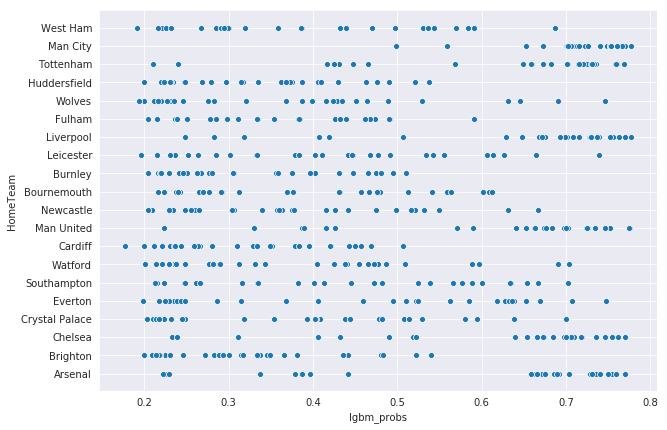

In [66]:
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(x="lgbm_probs", y="HomeTeam", data=xpbs)